# Random forest parameter-tuning
### Table of contents
1. [Data preprocessing](#Data-preprocessing)
2. [Validation curves](#Validation-curves)
3. [KS-test tuning](#KS-test-tuning)

In [1]:
import sys
sys.path.append('/home/jbourbeau/cr-composition')
print('Added to PYTHONPATH')

Added to PYTHONPATH


In [5]:
from __future__ import division, print_function
import argparse
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn.apionly as sns
import scipy.stats as stats

from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import validation_curve, GridSearchCV, cross_val_score, ParameterGrid, KFold

import composition as comp

sns.set_palette('muted')
sns.set_color_codes()
%matplotlib inline

## Data preprocessing
1. Load simulation dataframe and apply specified quality cuts
2. Extract desired features from dataframe
3. Get separate testing and training datasets

In [3]:
df, cut_dict = comp.load_sim(return_cut_dict=True)
selection_mask = np.array([True] * len(df))
standard_cut_keys = ['lap_reco_success', 'lap_zenith', 'num_hits_1_30', 'IT_signal',
                     'StationDensity', 'max_qfrac_1_30', 'lap_containment', 'energy_range_lap']
for key in standard_cut_keys:
    selection_mask *= cut_dict[key]

df = df[selection_mask]

feature_list, feature_labels = comp.get_training_features()
print('training features = {}'.format(feature_list))
X_train, X_test, y_train, y_test, le = comp.get_train_test_sets(
    df, feature_list, train_he=True, test_he=True)

print('number training events = ' + str(y_train.shape[0]))
print('number testing events = ' + str(y_test.shape[0]))

/home/jbourbeau/cr-composition/composition/load_sim.py:109: RuntimeWarning: divide by zero encountered in log10
  df['log_NChannels_1_30'] = np.nan_to_num(np.log10(df['NChannels_1_30']))


training features = ['lap_log_energy', 'InIce_log_charge_1_30', 'lap_cos_zenith', 'NChannels_1_30', 'log_s125', 'StationDensity']
number training events = 145932
number testing events = 62543


## Validation curves
(10-fold CV)

### Maximum depth

[CV] classifier__max_depth=1 .........................................
[CV] classifier__max_depth=2 .........................................
[CV] classifier__max_depth=3 .........................................
[CV] classifier__max_depth=4 .........................................
[CV] classifier__max_depth=5 .........................................
[CV] classifier__max_depth=6 .........................................
[CV] classifier__max_depth=7 .........................................
[CV] classifier__max_depth=8 .........................................
[CV] classifier__max_depth=9 .........................................
[CV] classifier__max_depth=10 ........................................
[CV] classifier__max_depth=11 ........................................
[CV] classifier__max_depth=12 ........................................
[CV] classifier__max_depth=13 ........................................
[CV] classifier__max_depth=14 ........................................
[CV] c

[Parallel(n_jobs=20)]: Done  75 out of 150 | elapsed:  2.7min remaining:  2.7min


[CV] ................................ classifier__max_depth=5 -   0.4s
[CV] classifier__max_depth=6 .........................................
[CV] ................................ classifier__max_depth=8 -   0.5s
[CV] classifier__max_depth=7 .........................................
[CV] ................................ classifier__max_depth=1 -   0.4s
[CV] classifier__max_depth=8 .........................................
[CV] ............................... classifier__max_depth=13 -   1.2s
[CV] classifier__max_depth=9 .........................................
[CV] ................................ classifier__max_depth=7 -   0.4s
[CV] classifier__max_depth=10 ........................................
[CV] ................................ classifier__max_depth=7 -   0.4s
[CV] classifier__max_depth=11 ........................................
[CV] ................................ classifier__max_depth=2 -   0.8s
[CV] classifier__max_depth=12 ........................................
[CV] .

[Parallel(n_jobs=20)]: Done 150 out of 150 | elapsed:  5.1min finished


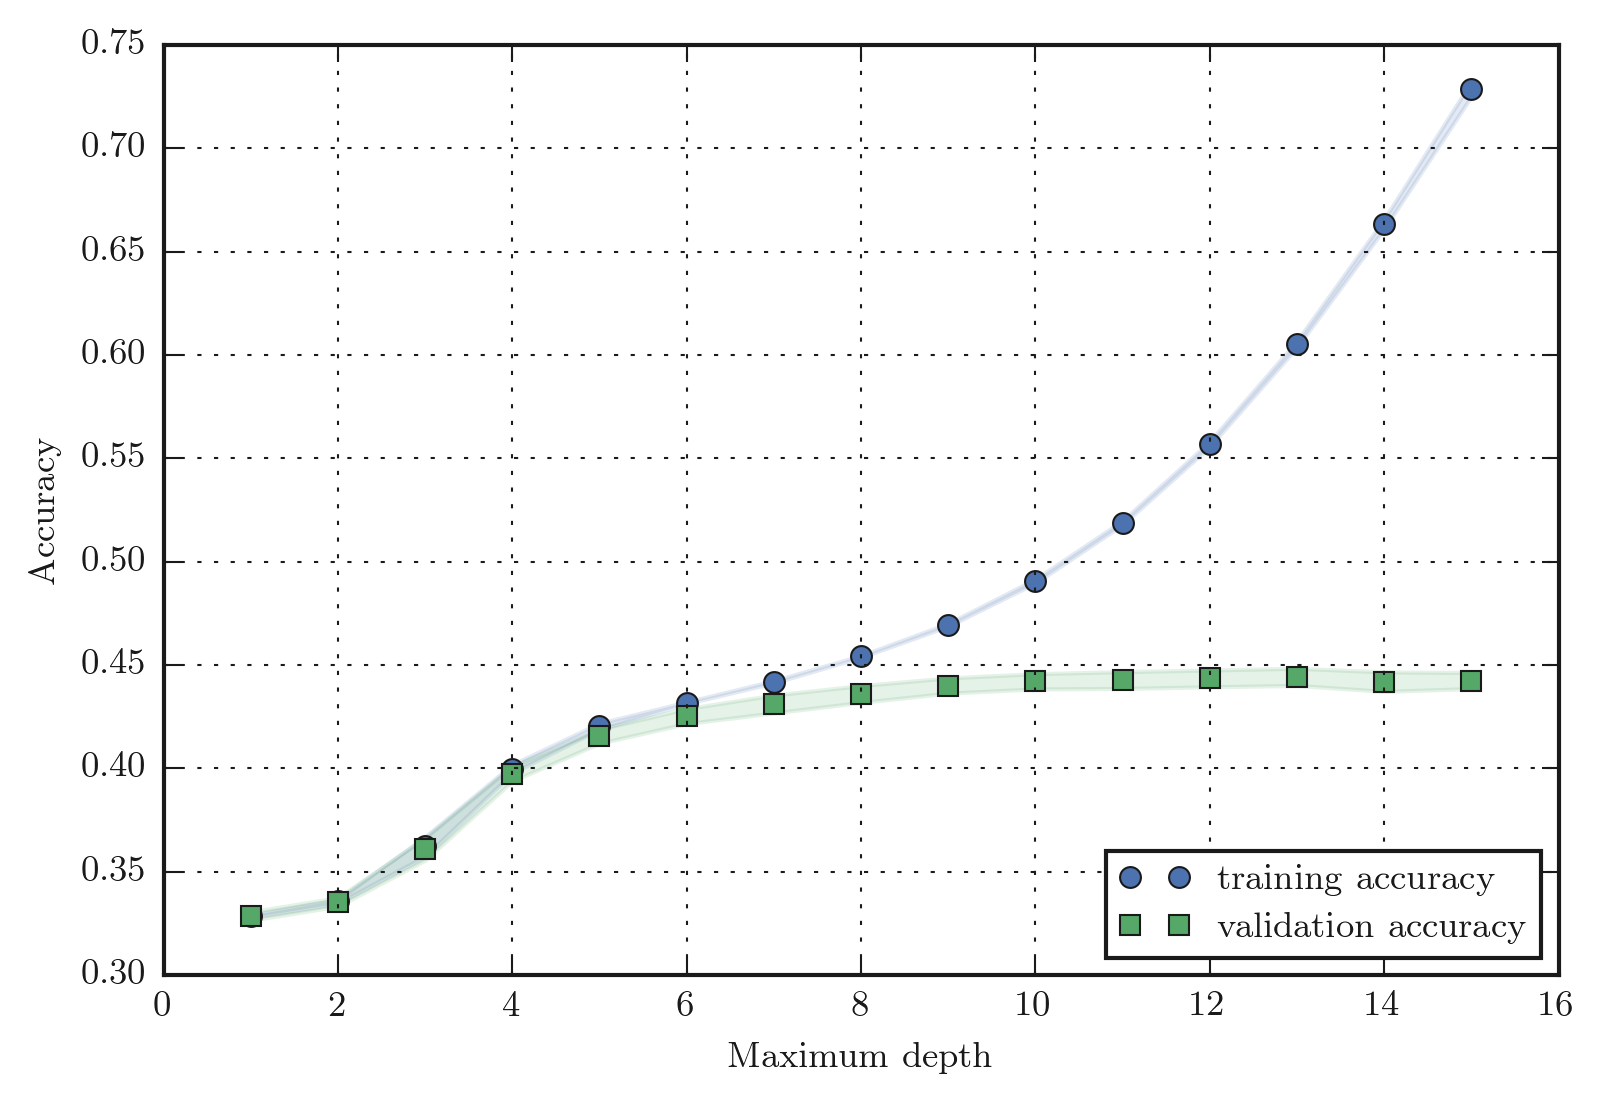

In [31]:
pipeline = comp.get_pipeline('RF')
param_range = np.arange(1, 16)
train_scores, test_scores = validation_curve(
                estimator=pipeline, 
                X=X_train, 
                y=y_train, 
                param_name='classifier__max_depth', 
                param_range=param_range,
                cv=10,
                verbose=2,
                n_jobs=20)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='b', marker='o', 
         markersize=5, label='training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='b')

plt.plot(param_range, test_mean, 
         color='g', linestyle='None', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='g')

plt.grid()
# plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Maximum depth')
plt.ylabel('Accuracy')
# plt.ylim([0.8, 1.0])
# plt.savefig('/home/jbourbeau/public_html/figures/composition/parameter-tuning/RF-validation_curve_min_samples_leaf.png', dpi=300)
plt.show()

### Minimum samples in leaf node

[CV] classifier__min_samples_leaf=1 ..................................
[CV] classifier__min_samples_leaf=26 .................................
[CV] classifier__min_samples_leaf=51 .................................
[CV] classifier__min_samples_leaf=76 .................................
[CV] classifier__min_samples_leaf=101 ................................
[CV] classifier__min_samples_leaf=126 ................................
[CV] classifier__min_samples_leaf=151 ................................
[CV] classifier__min_samples_leaf=176 ................................
[CV] classifier__min_samples_leaf=201 ................................
[CV] classifier__min_samples_leaf=226 ................................
[CV] classifier__min_samples_leaf=251 ................................
[CV] classifier__min_samples_leaf=276 ................................
[CV] classifier__min_samples_leaf=301 ................................
[CV] classifier__min_samples_leaf=326 ................................
[CV] c

[Parallel(n_jobs=20)]: Done  80 out of 160 | elapsed:  2.2min remaining:  2.2min


[CV] classifier__min_samples_leaf=76 .................................
[CV] ........................ classifier__min_samples_leaf=26 -   0.7s
[CV] classifier__min_samples_leaf=126 ................................
[CV] ........................ classifier__min_samples_leaf=76 -   1.9s
[CV] classifier__min_samples_leaf=151 ................................
[CV] ........................ classifier__min_samples_leaf=76 -   2.8s
[CV] classifier__min_samples_leaf=176 ................................
[CV] ....................... classifier__min_samples_leaf=126 -   0.9s
[CV] classifier__min_samples_leaf=201 ................................
[CV] ....................... classifier__min_samples_leaf=126 -   0.5s
[CV] classifier__min_samples_leaf=226 ................................
[CV] ....................... classifier__min_samples_leaf=251 -   1.1s
[CV] ....................... classifier__min_samples_leaf=201 -   0.4s
[CV] classifier__min_samples_leaf=276 ................................
[CV] c

[Parallel(n_jobs=20)]: Done 160 out of 160 | elapsed:  4.1min finished


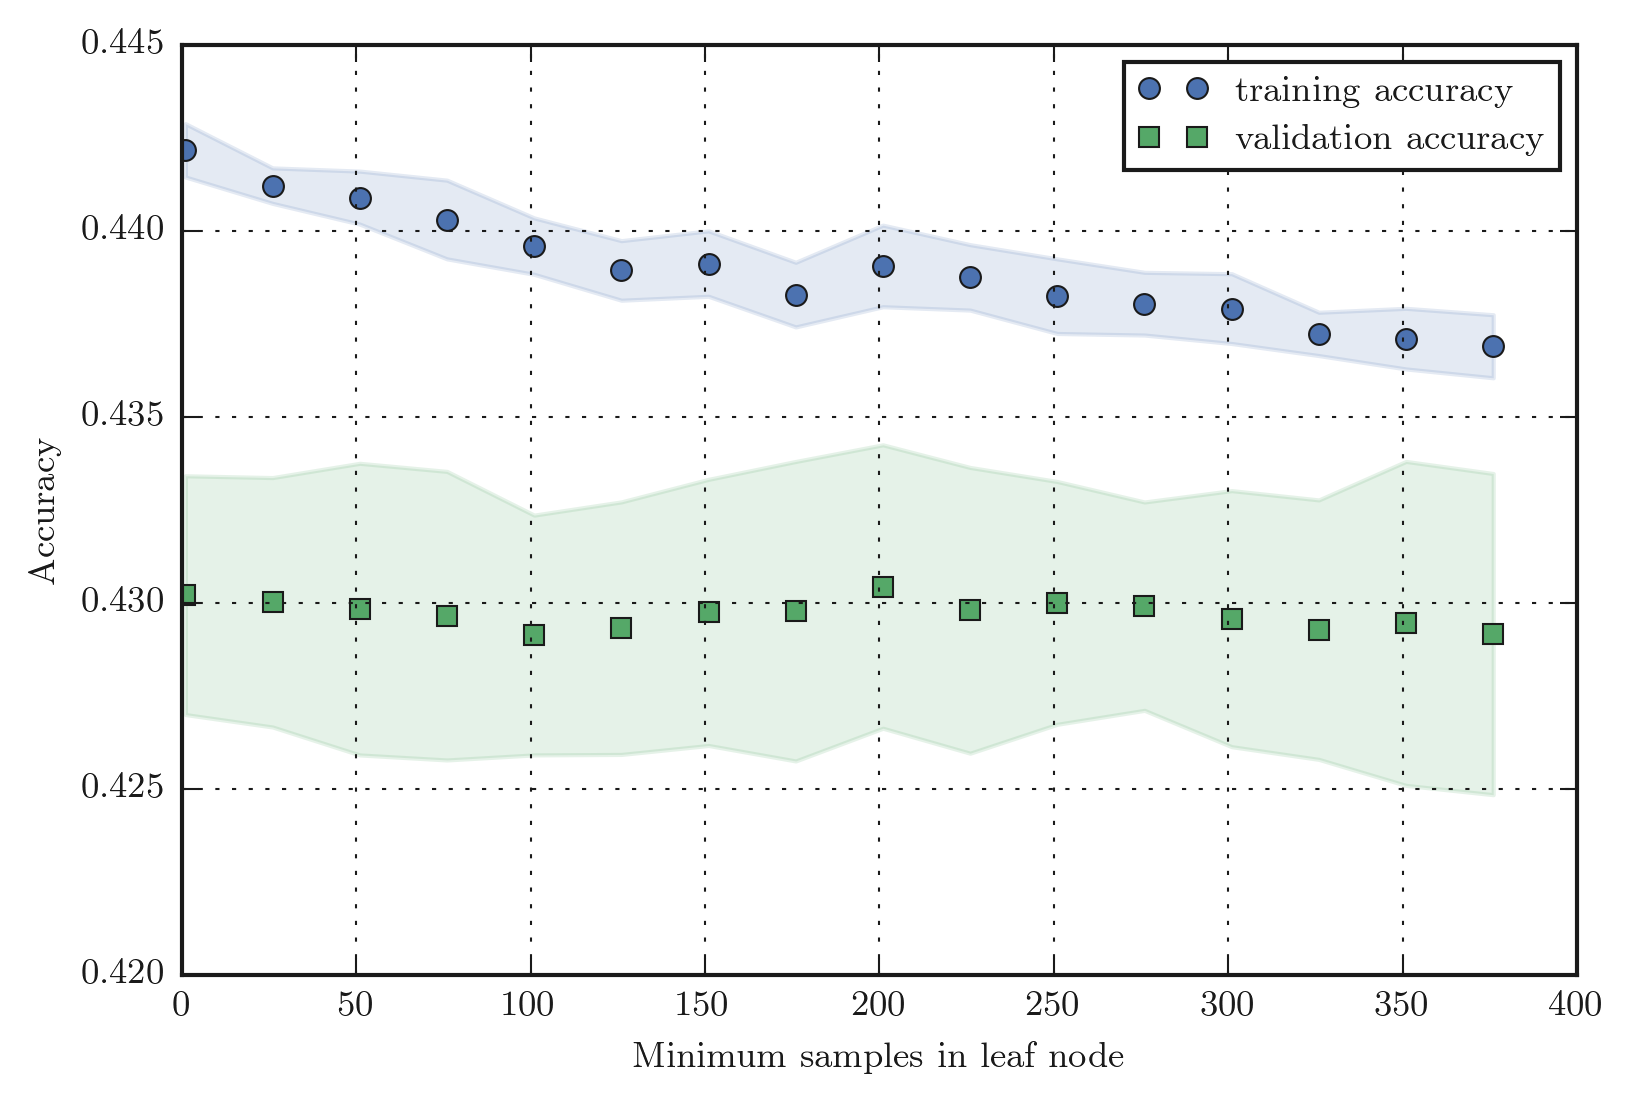

In [5]:
pipeline = comp.get_pipeline('RF')
param_range = np.arange(1, 400, 25)
train_scores, test_scores = validation_curve(
                estimator=pipeline, 
                X=X_train, 
                y=y_train, 
                param_name='classifier__min_samples_leaf', 
                param_range=param_range,
                cv=10,
                verbose=2,
                n_jobs=20)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='b', marker='o', 
         markersize=5, label='training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='b')

plt.plot(param_range, test_mean, 
         color='g', linestyle='None', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='g')

plt.grid()
# plt.xscale('log')
plt.legend()
plt.xlabel('Minimum samples in leaf node')
plt.ylabel('Accuracy')
# plt.ylim([0.8, 1.0])
# plt.savefig('/home/jbourbeau/public_html/figures/composition/parameter-tuning/RF-validation_curve_min_samples_leaf.png', dpi=300)
plt.show()

NameError: name 'get_pipeline' is not defined

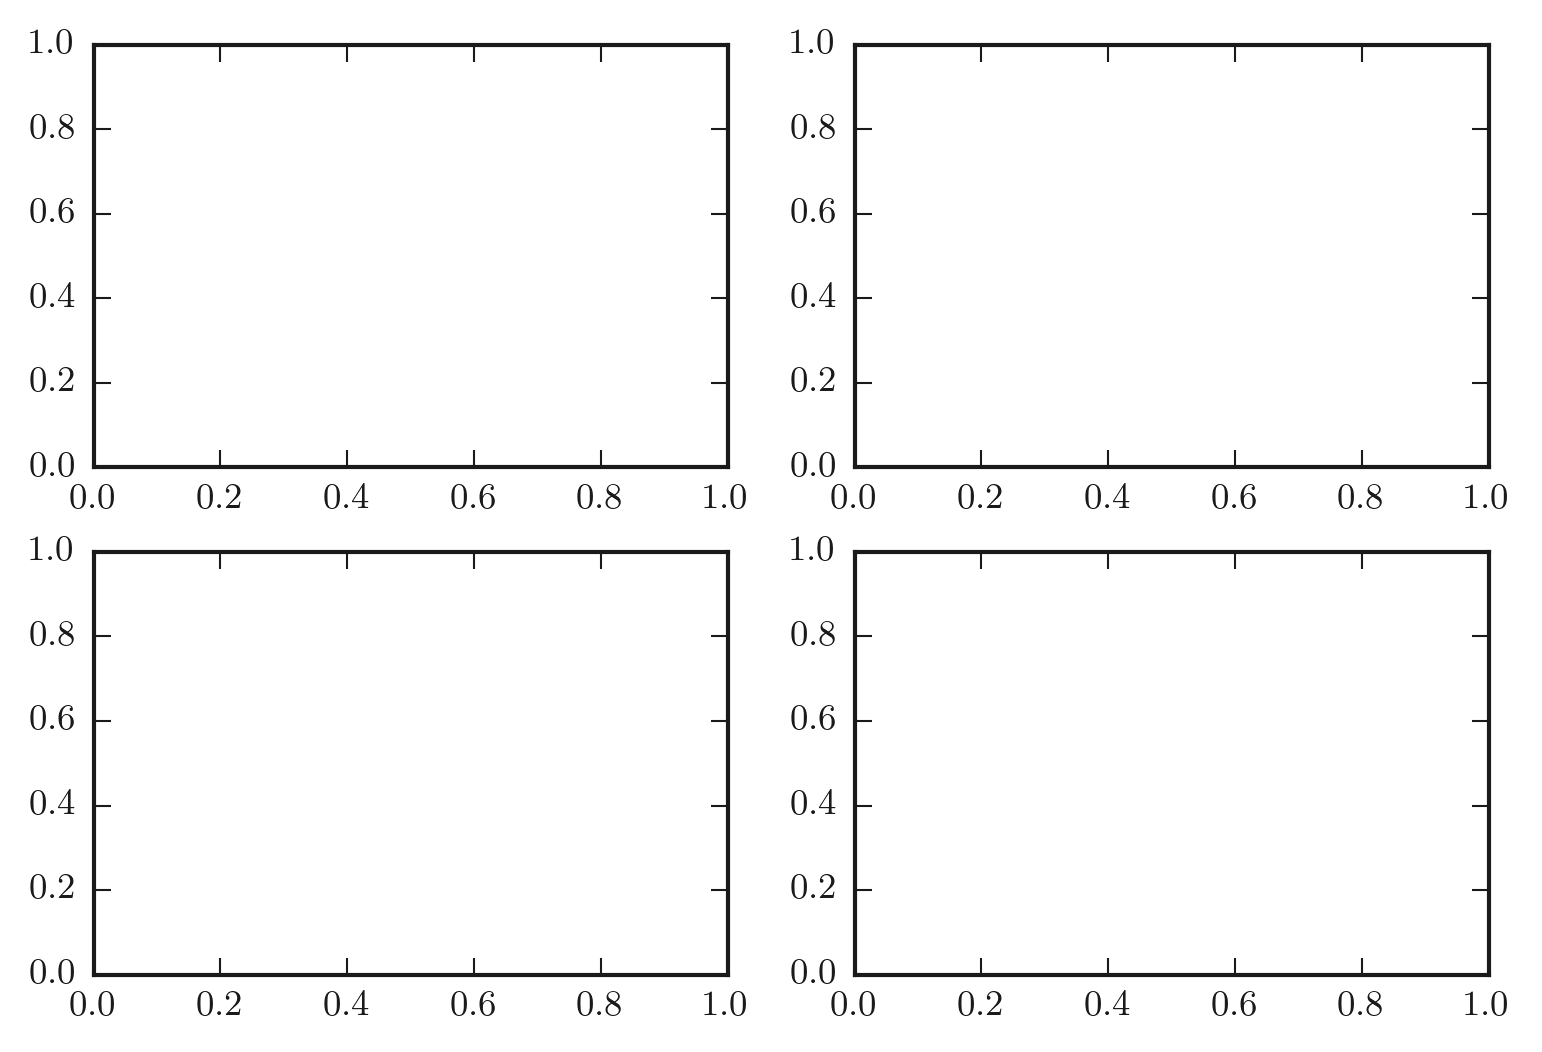

In [6]:
max_depth_list = [2, 8, 10, 20]

fig, axarr = plt.subplots(2,2)
for depth, ax in zip(max_depth_list, axarr.flatten()):
    pipeline = get_pipeline('RF')
    pipeline.named_steps['classifier'].set_params(max_depth=depth)
    pipeline.fit(X_train, y_train)
    scaler = pipeline.named_steps['scaler']
    clf = pipeline.named_steps['classifier']
    X_test_std = scaler.transform(X_test)
    plot_decision_regions(X_test_std, y_test, clf, scatter_fraction=None, ax=ax)
    ax.set_xlabel('Scaled energy')
    ax.set_ylabel('Scaled charge')
    ax.set_title('Max depth = {}'.format(depth))
    ax.legend()
plt.tight_layout()
plt.savefig('/home/jbourbeau/public_html/figures/composition/parameter-tuning/RF-decision-regions.png')


In [ ]:
pipeline = get_pipeline('RF')
param_range = np.arange(1, 20)
param_grid = {'classifier__max_depth': param_range}
gs = GridSearchCV(estimator=pipeline, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  n_jobs=10)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

## KS-test tuning

### Maximum depth

In [38]:
comp_list = ['P', 'He', 'O', 'Fe']
max_depth_list = np.arange(1, 16)
pval_comp = defaultdict(list)
ks_stat = defaultdict(list)
kf = KFold(n_splits=10)
fold_num = 0
for train_index, test_index in kf.split(X_train):
    fold_num += 1
    print('\r')
    print('Fold {}: '.format(fold_num), end='')
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
    pval_maxdepth = defaultdict(list)
    print('max_depth = ', end='')
    for max_depth in max_depth_list:
        print('{}...'.format(max_depth), end='')
        pipeline = comp.get_pipeline('RF')
        pipeline.named_steps['classifier'].set_params(max_depth=max_depth)
        pipeline.fit(X_train_fold, y_train_fold)
        test_probs = pipeline.predict_proba(X_test_fold)
        train_probs = pipeline.predict_proba(X_train_fold)
        for class_ in pipeline.classes_:
            pval_maxdepth[le.inverse_transform(class_)].append(stats.ks_2samp(test_probs[:, class_], train_probs[:, class_])[1])
    for composition in comp_list:
        pval_comp[composition].append(pval_maxdepth[composition])
pval_sys_err = {key: np.std(pval_comp[key], axis=0) for key in pval_comp}
pval = {key: np.mean(pval_comp[key], axis=0) for key in pval_comp}


Fold 1: max_depth = 1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...
Fold 2: max_depth = 1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...
Fold 3: max_depth = 1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...
Fold 4: max_depth = 1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...
Fold 5: max_depth = 1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...
Fold 6: max_depth = 1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...
Fold 7: max_depth = 1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...
Fold 8: max_depth = 1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...
Fold 9: max_depth = 1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...
Fold 10: max_depth = 1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...

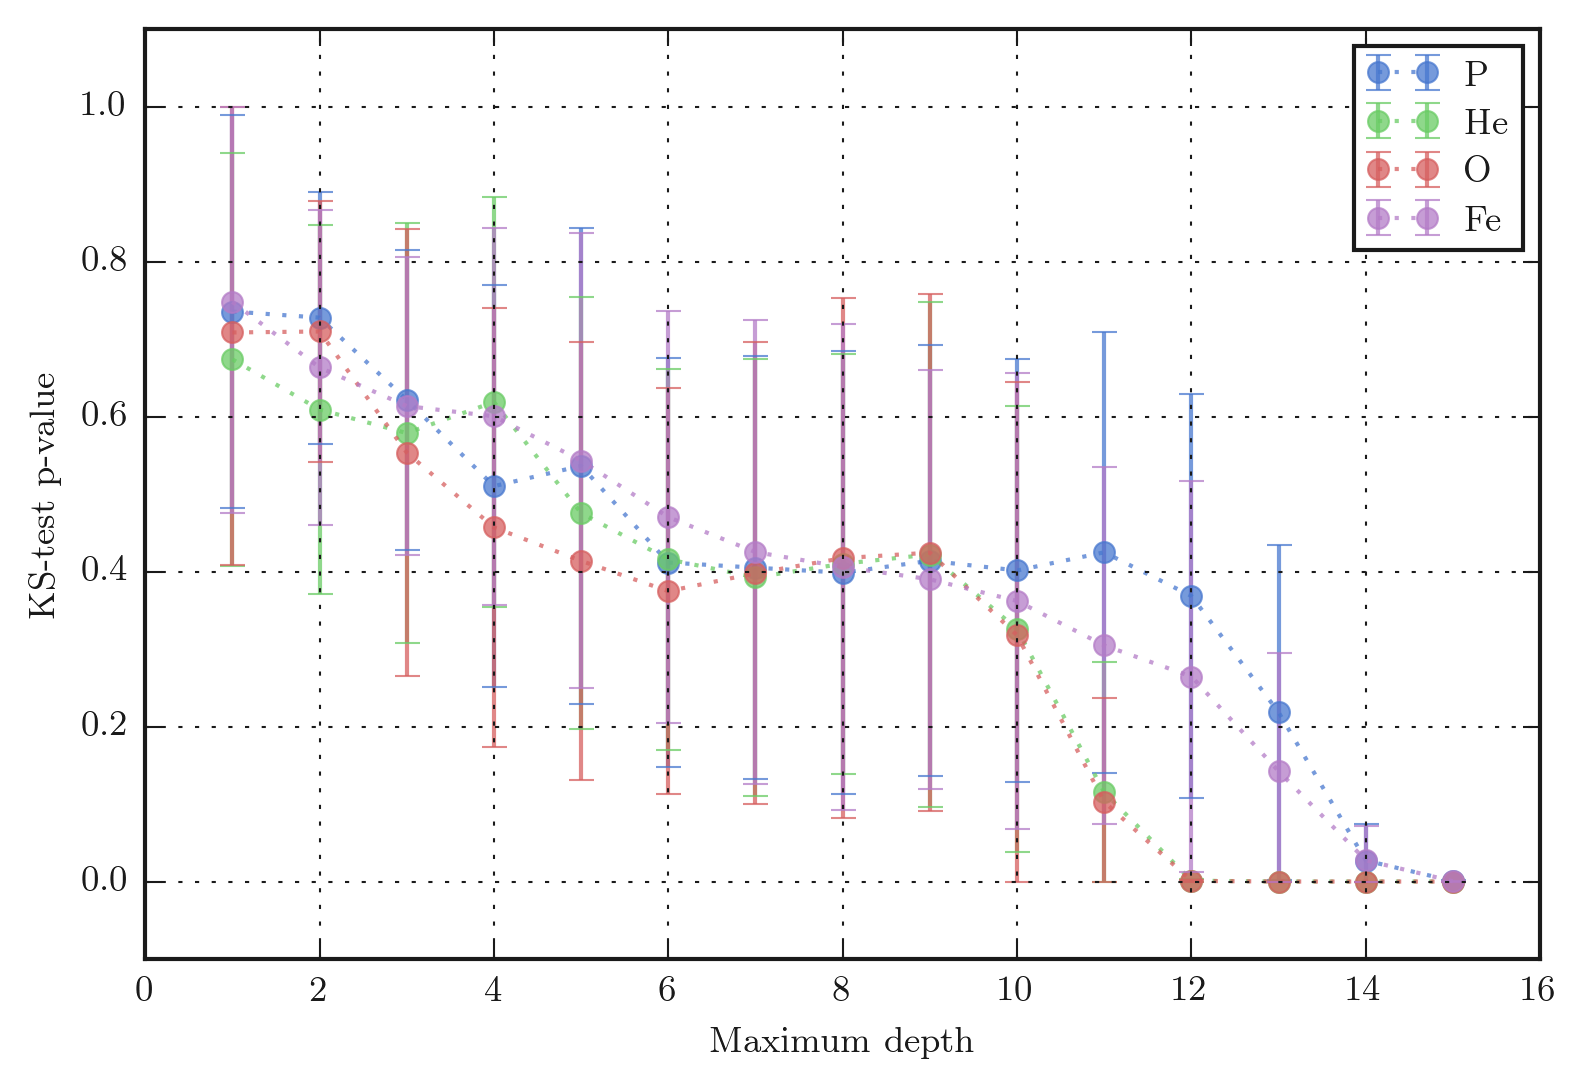

In [53]:
fig, ax = plt.subplots()
for composition in comp_list:
    upper_err = np.copy(pval_sys_err[composition])
    upper_err = [val if ((pval[composition][i] + val) < 1) else 1-pval[composition][i] for i, val in enumerate(upper_err)]
    lower_err = np.copy(pval_sys_err[composition])
    lower_err = [val if ((pval[composition][i] - val) > 0) else pval[composition][i] for i, val in enumerate(lower_err)]
    ax.errorbar(max_depth_list, pval[composition],
                yerr=[lower_err, upper_err],
                marker='.', linestyle=':',
                label=composition, alpha=0.75)
plt.ylabel('KS-test p-value')
plt.xlabel('Maximum depth')
plt.ylim([-0.1, 1.1])
leg = plt.legend()
# # set the linewidth of each legend object
# for legobj in leg.legendHandles:
#     legobj.set_linestyle('-')
#     legobj.set_linewidth(3.0)
# #     legobj.set_dashes('None')
plt.grid()
plt.show()

In [ ]:
legobj.

### Minimum samples in leaf node

In [ ]:
comp_list = np.unique(df['MC_comp'])
min_samples_list = np.arange(1, 400, 25)
pval = defaultdict(list)
ks_stat = defaultdict(list)
print('min_samples_leaf = ', end='')
for min_samples_leaf in min_samples_list:
    print('{}...'.format(min_samples_leaf), end='')
    pipeline = comp.get_pipeline('RF')
    params = {'max_depth': 4, 'min_samples_leaf': min_samples_leaf}
    pipeline.named_steps['classifier'].set_params(**params)
    pipeline.fit(X_train, y_train)
    test_probs = pipeline.predict_proba(X_test)
    train_probs = pipeline.predict_proba(X_train)
    for class_ in pipeline.classes_:
        pval[le.inverse_transform(class_)].append(stats.ks_2samp(test_probs[:, class_], train_probs[:, class_])[1])
fig, ax = plt.subplots()
for composition in pval:
    ax.plot(min_samples_list, pval[composition], linestyle='-.', label=composition)
plt.ylabel('KS-test p-value')
plt.xlabel('Minimum samples leaf node')
plt.legend()
plt.grid()
plt.show()

### Maximum depth for various minimum samples in leaf node

In [ ]:
comp_list = np.unique(df['MC_comp'])
min_samples_list = [1, 25, 50, 75]
# min_samples_list = [1, 100, 200, 300]
fig, axarr = plt.subplots(2, 2, sharex=True, sharey=True)
print('min_samples_leaf = ', end='')
for min_samples_leaf, ax in zip(min_samples_list, axarr.flatten()):
    print('{}...'.format(min_samples_leaf), end='')
    max_depth_list = np.arange(1, 16)
    pval = defaultdict(list)
    ks_stat = defaultdict(list)
    for max_depth in max_depth_list:
        pipeline = comp.get_pipeline('RF')
        params = {'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf}
        pipeline.named_steps['classifier'].set_params(**params)
        pipeline.fit(X_train, y_train)
        test_probs = pipeline.predict_proba(X_test)
        train_probs = pipeline.predict_proba(X_train)
        for class_ in pipeline.classes_:
            pval[le.inverse_transform(class_)].append(stats.ks_2samp(test_probs[:, class_], train_probs[:, class_])[1])
    for composition in pval:
        ax.plot(max_depth_list, pval[composition], linestyle='-.', label=composition)
    ax.set_ylabel('KS-test p-value')
    ax.set_xlabel('Maximum depth')
    ax.set_title('min samples = {}'.format(min_samples_leaf))
    ax.set_ylim([0, 0.5])
    ax.legend()
    ax.grid()
plt.tight_layout()
plt.show()